# Create Session Report

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np

from convnwb.io import load_nwbfile

from spiketools.spatial.occupancy import compute_occupancy

from spiketools.plts.data import plot_bar, plot_hist, plot_text
from spiketools.plts.spatial import plot_heatmap, plot_positions
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.utils import make_grid, get_grid_subplot

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from utils import select_navigation, stack_trials
from reports import (create_units_info, create_units_str,
                     create_position_info, create_position_str,
                     create_behav_info, create_behav_str)

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Define bins to use
bins = [9, 12]

# Define minimum occupancy
min_occ = 1
speed_thresh = 5e-6

## Load Data

In [8]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

## Extract Data

In [9]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

In [10]:
# Get position data, selecting from navigation periods, and recombine across trials
ptimes_trials, positions_trials = select_navigation(\
    nwbfile.acquisition['position']['player_position'], nav_starts, nav_stops)
ptimes, positions = stack_trials(ptimes_trials, positions_trials)

# Get speed data, selecting from navigation periods, and recombining across trials
stimes, speed = stack_trials(*select_navigation(\
    nwbfile.processing['position_measures']['speed'], nav_starts, nav_stops))

## Collect Information

In [11]:
# Collect information
units_info = create_units_info(nwbfile.units)
behav_info = create_behav_info(nwbfile.trials)
pos_info = create_position_info(nwbfile.acquisition, bins)

### Compute Occupancy

In [12]:
# Compute occupancy
pos_info['occupancy'] = compute_occupancy(\
    positions, ptimes, bins, pos_info['area_range'], speed,
    speed_thresh, minimum=min_occ, set_nan=True)

## Create Report

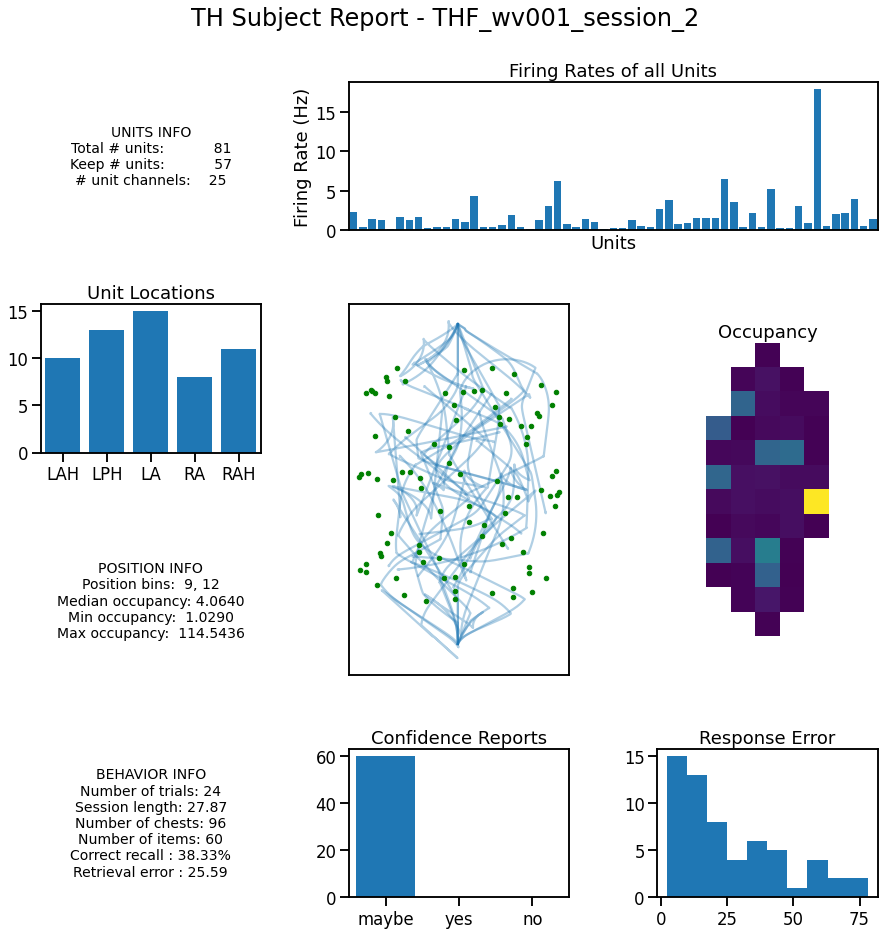

In [13]:
# Initialize figure with grid layout
grid = make_grid(4, 3, wspace=0.4, hspace=0.5, figsize=(15, 15),
                 title='TH Subject Report - {}'.format(nwbfile.session_id))

# 00: units text
plot_text(create_units_str(units_info), ax=get_grid_subplot(grid, 0, 0))

# 01: neuron fig
plot_firing_rates(units_info['frs'], xticks=[], ax=get_grid_subplot(grid, 0, slice(1, None)))

# 10: unit locations plot
plot_bar(units_info['location_counts'].values(), units_info['location_counts'].keys(),
         title='Unit Locations', ax=get_grid_subplot(grid, 1, 0))

# 11: subject positions overlaid with chest positions
plot_positions(positions_trials,
               landmarks={'positions' : pos_info['chests'], 'color' : 'green'},
               ax=get_grid_subplot(grid, slice(1, 3), 1))

# 12: occupancy map
plot_heatmap(pos_info['occupancy'], title='Occupancy',
             ax=get_grid_subplot(grid, slice(1, 3), 2))

# 20: position text
plot_text(create_position_str(pos_info), ax=get_grid_subplot(grid, 2, 0))

# 30: behaviour text
plot_text(create_behav_str(behav_info), ax=get_grid_subplot(grid, 3, 0))

# 31: choice point plot
plot_bar(behav_info['confidence_counts'].values(), behav_info['confidence_counts'].keys(),
         title='Confidence Reports', ax=get_grid_subplot(grid, 3, 1))

# 32: errors plot
plot_hist(nwbfile.trials.error.data[:], title='Response Error', ax=get_grid_subplot(grid, 3, 2))